# Trend-following

This notebook displays the performance of trend-following strategies across major asset classes. The trend signal used here is the same as the one proposed in Moskowitz et al (2012) to illustrate the basic properties of trend-following strategies. Concretely, the signal at time $t$ is defined in the paper as follows:
$$
signal_t^s = {\rm sign} \left( r_{t-12, t}^{s} \right) \frac{40\%}{\sigma_{t}^{s}}  
$$
where $r_{t-12, t}^{s}$ is a return from time $t-12$ to $t$ for an instrument $s$ (return is measured on a monthly basis), $\sigma_{t}^{s}$ is a trailing realised volatility. Therefore the trend signal is just binary based on the past 1 year returns, adjusted by the realised volatility to achieve the target volatility (40%).

Note that like the notebook for long-only returns, results are computed by using a private library called `vivace`.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.contract import all_futures_moskowitz2012
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance, PerfStats
from vivace.enums import Strategy, Weighting

# Data

In [2]:
all_futures_moskowitz2012['name'].values

array(['Aluminium', 'Brent Crude Oil', 'Live Cattle', 'Cocoa', 'Coffee',
       'Copper', 'Corn', 'Cotton', 'WTI Crude Oil', 'Gas Oil', 'Gold',
       'Heating Oil', 'Lean Hog', 'Natural Gas', 'Nickel', 'Platinum',
       'Silver', 'Soybean', 'Soybean Meal', 'Soybean Oil', 'Sugar',
       'Gasoline', 'Wheat', 'Zinc', 'Australian Dollar', 'British Pound',
       'Euro', 'Canadian Dollar', 'Japanese Yen', 'SPI 200', 'DAX',
       'IBEX 35', 'CAC 40', 'Topix', 'AEX', 'FTSE 100', 'S&P 500',
       'Australia 3-year Treasury', 'Australia 10-year Treasury',
       'Germany Schatz', 'Germany Bobl', 'Germany Bund', 'Germany Buxl',
       'Canada 10-year Treasury', 'JGB', 'Gilt', 'US 2-year Treasury',
       'US 5-year Treasury', 'US 10-year Treasury', 'US Treasury Bond'],
      dtype=object)

In [3]:
len(all_futures_moskowitz2012)

50

We try to use the same contract as the original paper where possible, resulting 50 futures contracts to analyse. The trading universe covers a wide range of asset classes and regions, and is made up of following instruments:
- Equity index futures
- Government bond futures
- FX futures
- Commodity futures

where the same trend detection method is applied.

# Performance

## Run backtest
We can initiate an engine instance by specifying certain signal methodologies. Here in addition to using the proposed trend signal formula, the signal is then observed on a monthly basis to be in line with the assumption of the paper. (defined in the `post_process` argument).  

The calculation of signal itself requires just one line and is implemented like follows (in the `calculate` method):
```python
class TSMOMMoskowitz2012(TimeSeriesSignal):
    def __init__(self, lookback: int = 252, shift: int = 2,
                 post_process=processing.AsFreq(freq='m', method='pad')):
        super().__init__()
        self.lookback = lookback
        self.shift = shift
        self.post_process = post_process

    def calculate(self, instrument_return: pd.Series, *args, **kwargs) -> pd.Series:
        signal = instrument_return.rolling(self.lookback).sum().fillna(0).pipe(np.sign).shift(self.shift)
        return signal
```

Furthermore, the ex-ante voaltility is measured by the exponentially weighted standard deviation with the center of mass of 60 days, as used in the paper. One difference from the paper is that the backtest also employs a cap on the volatility scaling (parameter `signal_cap`) in order to ensure that leverages are below trailing 95%ile. This is required for certain commodity futures because they had significantly large returns which could bankrupt the backtest in the early days.

In [4]:
engine = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_moskowitz2012.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(agg_method='ewm', com=60, ann_factor=261, 
                               target_volatility=0.4, signal_cap=0.95,
                               post_process=processing.AsFreq(freq='m', method='pad')),
        signal.TSMOMMoskowitz2012(post_process=processing.AsFreq(freq='m', method='pad'))
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine.run()

## Portfolio

The portfolio is constructed with a equal-risk (realised volatility) weighting methodology. This is simple to compute however in practice this is not desiable because of various reasons. The biggest reason is liquidity because not all of the futures have the same liquidity. Certainly S&P500 futures would have much deeper liquidity than some other isoteric commodity futures.

In [5]:
portfolio_return = (engine.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                    .rename('Trend-following portfolio (Moskowitz 2012)'))

This portfolio worked well over 60 years with a Sharpe ratio of above 1.0 (gross of costs), however notice that this naive implementation of trend following seems to have somewhat weakened since around 2015.

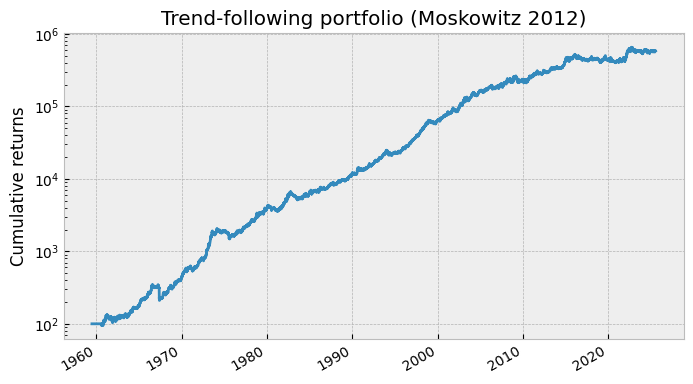

In [6]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio (Moskowitz 2012)')
ax.set_ylabel('Cumulative returns');

In [7]:
portfolio_return.pipe(Performance).summary()

,Trend-following portfolio (Moskowitz 2012)
CAGR,0.128338
Annualised vol,0.123101
Sharpe ratio,1.042547
Max drawdown,0.394379
Calmar ratio,0.325419
Skewness,-0.328696
Kurtosis,7.075128
Worst return,-0.084174
Worst 1d return,-0.084174
Worst 1w return,-0.150155


## Breakdown by futures contract

Most of the contracts contributed positively when the trend-following signal is applied.

In [8]:
instrument_returns = engine.get_return_by_instrument(calculate_net=False).cumsum()

In [9]:
instrument_sharpe = (instrument_returns.pipe(Performance, return_type='diff').summary()
                     .loc[PerfStats.SHARPE.value, :]
                     .to_frame().join(all_futures_moskowitz2012)
                     .sort_values(['asset_class', 'name'])
                     .set_index('name')
                     .squeeze())

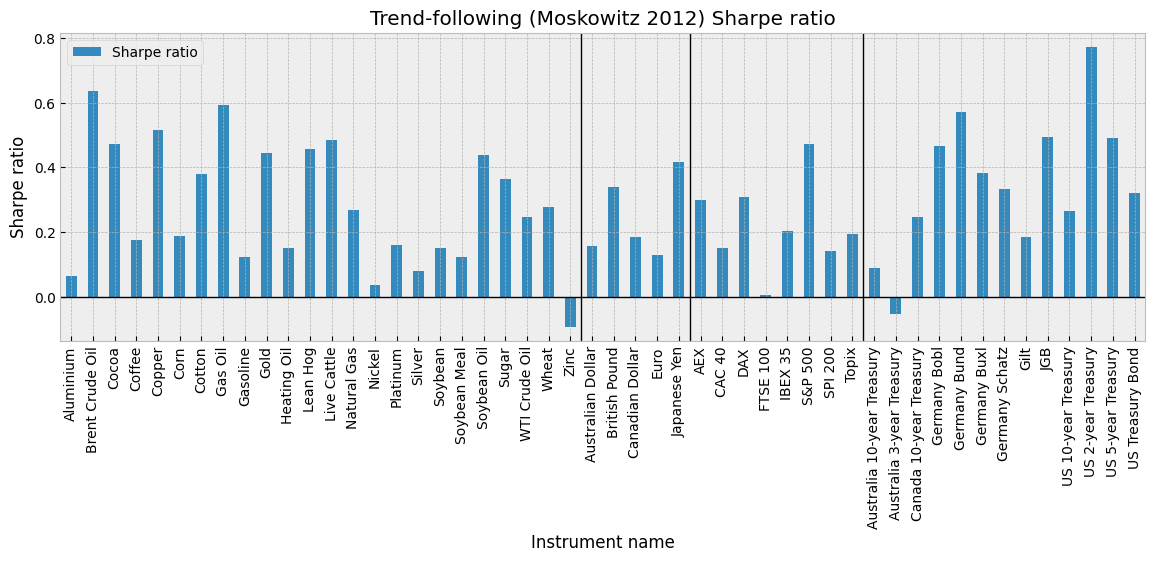

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
instrument_sharpe.plot(kind='bar', ax=ax)

ax.set_title('Trend-following (Moskowitz 2012) Sharpe ratio')
ax.set_ylabel(PerfStats.SHARPE.value);
ax.set_xlabel('Instrument name')
ax.axhline(0, lw=1, color='black');
ax.axvline(23.5, lw=1, color='black');
ax.axvline(28.5, lw=1, color='black');
ax.axvline(36.5, lw=1, color='black');

## Post puiblication

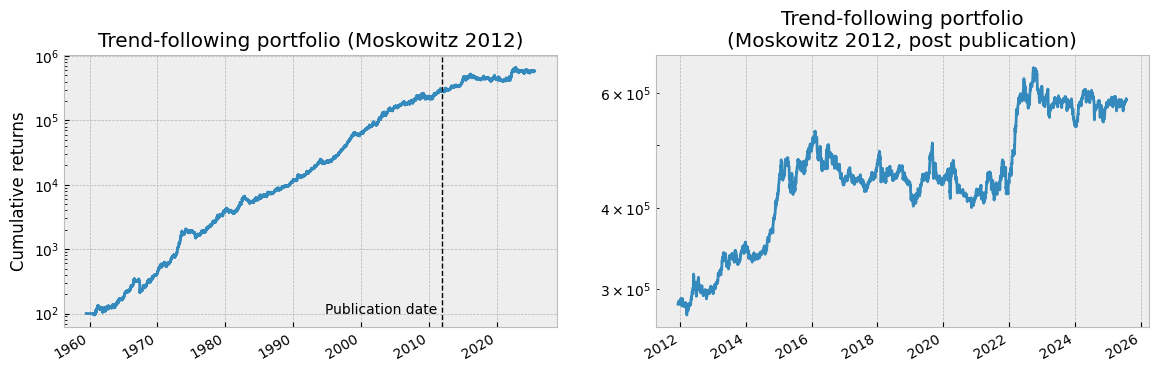

In [11]:
publication_date = datetime(2011, 12, 11)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
portfolio_return.plot(ax=ax[0], logy=True);
ax[0].set_title('Trend-following portfolio (Moskowitz 2012)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

portfolio_return.loc[publication_date:].plot(ax=ax[1], logy=True);
ax[1].set_title('Trend-following portfolio\n(Moskowitz 2012, post publication)');

## Recent performance

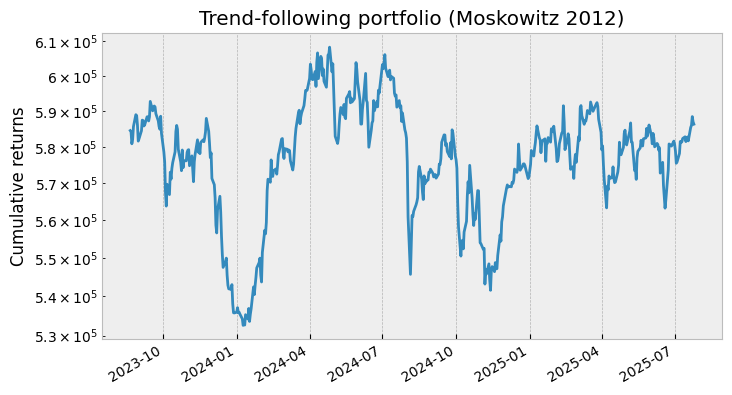

In [12]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio (Moskowitz 2012)')
ax.set_ylabel('Cumulative returns');

# Reference

- Moskowitz, T.J., Ooi, Y.H. and Pedersen, L.H., 2012. Time series momentum. Journal of financial economics, 104(2), pp.228-250.

In [13]:
print(f'Updated: {datetime.now(pytz.utc).strftime("%d-%b-%Y %H:%M")}')

Updated: 26-Jul-2025 01:21
